##############################################################################
##############################################################################
### **Atelier "Faire du Machine Learning et du Deep Learning sur des Time Series"**
##############################################################################
##############################################################################
<br>
<br>
<br>
<br>
#### **Partie 2 : Machine Learning sur des Times Series multivariée** 

Dans cette deuxième partie, nous allons ajouter des variables exogènes à la série univariée historique de consommation d'électricité de la métropole de Brest. Nous allons rajouter tout d'abord des donnée météorologiques, puis des données liées aux évènements calendaires.
<br>
<br>
Niveau Modèles, nous allons entrainer un LSTM, qui est tout à fait designé pour gérer des séries multivariées. La phase un peu compliquée sera celle de la création des séquences qui serviront de séquence historique pour une inférence.
<br>
<br>
En bonus, nous explorerons le premier modèle de fondation pour données multivariée, MOIRAI, qui est capable de faire des prédictions en zero-shot learning. Nous verrons si cette approche permet déjà des résultats corrects
<br>


## Section 0 : récupération, préparation et Fusion des Datasets ##

L'analyse multivariée repose sur l'intégration de variables exogènes (externes) pour améliorer la précision prédictive. Ici, nous fusionnons les données de consommation électrique avec les données météorologiques.

    Alignement temporel : Synchronisation des deux sources sur un index commun via une jointure interne (inner merge).

  

In [ ]:
import requests
import pandas as pd
import time

def fetch_brest_electricity_data():
    base_url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-metropoles-tr/exports/json"
    
    # Paramètres de la requête
    params = {
        "where": "libelle_metropole='Brest Métropole' AND date_heure >= '2020-01-01' AND date_heure <= '2025-12-31'",
        "order_by": "date_heure ASC",
        "timezone": "UTC"
    }
    
    print("Récupération des données pour Brest Métropole (2020-2025)...")
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        
        data = response.json()
        df = pd.DataFrame(data)
        print(df.head())
            
        df = df[['date_heure', 'consommation']].dropna()
        
        print(f"Chargement Terminé ! {len(df)} lignes récupérées.")
        return df

    except Exception as e:
        print(f"Erreur lors de la récupération : {e}")
        return None


df_conso_brest = fetch_brest_electricity_data()

if df_conso_brest is not None:
    print(df_conso_brest.head())
    # Sauvegarde pour l'atelier
    df_conso_brest.to_csv("conso_brest_2020_2025.csv", index=False)

Récupération des données pour Brest Métropole (2020-2025)...
  code_insee_epci libelle_metropole              nature        date heures  \
0       242900314   Brest Métropole  Données temps réel  2020-01-01  01:00   
1       242900314   Brest Métropole  Données temps réel  2020-01-01  01:15   
2       242900314   Brest Métropole  Données temps réel  2020-01-01  01:30   
3       242900314   Brest Métropole  Données temps réel  2020-01-01  01:45   
4       242900314   Brest Métropole  Données temps réel  2020-01-01  02:00   

                  date_heure  consommation production echanges_physiques  
0  2020-01-01T00:00:00+00:00         106.0       None               None  
1  2020-01-01T00:15:00+00:00         108.0       None               None  
2  2020-01-01T00:30:00+00:00         113.0       None               None  
3  2020-01-01T00:45:00+00:00         121.0       None               None  
4  2020-01-01T01:00:00+00:00         119.0       None               None  
Chargement Terminé !

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


# 1. indexation temporelle
df_conso_brest = df_conso_brest.rename(columns={"date_heure": "date"})
df_conso_brest['date'] = pd.to_datetime(df_conso_brest['date'], utc=True)
df_conso_brest = df_conso_brest.set_index('date').sort_index()

# changement de temporalité des données
df_conso_brest_journ = df_conso_brest['consommation'].resample('D').mean().interpolate()




In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Configuration de l'API avec cache et relance automatique en cas d'erreur
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

def get_weather_data_brest(start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": 48.3904, # Brest
        "longitude": -4.4861,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "shortwave_radiation"],
        "timezone": "Europe/Berlin"
    }
    
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    # Processus de transformation des données horaires
    hourly = response.Hourly()
    hourly_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}
    
    hourly_data["temp_moy"] = hourly.Variables(0).ValuesAsNumpy()
    hourly_data["humidity"] = hourly.Variables(1).ValuesAsNumpy()
    hourly_data["vent_vitesse"] = hourly.Variables(2).ValuesAsNumpy()
    hourly_data["rayonnement_moyen"] = hourly.Variables(3).ValuesAsNumpy()

    df_meteo = pd.DataFrame(data=hourly_data)
    
    # Passage en format journalier
    df_meteo_journ = df_meteo.resample('D', on='date').mean()
    
    return df_meteo_journ


df_meteo_brest_journ = get_weather_data_brest("2020-01-01", "2025-12-31")
print(df_meteo_brest_journ.head())

                            temp_moy   humidity  vent_vitesse  \
date                                                            
2019-12-31 00:00:00+00:00  10.150000  97.032616      9.470120   
2020-01-01 00:00:00+00:00   9.158334  96.470070      6.283340   
2020-01-02 00:00:00+00:00  10.312500  91.239723     22.854681   
2020-01-03 00:00:00+00:00   9.056251  85.719337     18.014933   
2020-01-04 00:00:00+00:00   7.085417  81.455223      6.970688   

                           rayonnement_moyen  
date                                          
2019-12-31 00:00:00+00:00           0.000000  
2020-01-01 00:00:00+00:00          30.083334  
2020-01-02 00:00:00+00:00          27.291666  
2020-01-03 00:00:00+00:00          20.166666  
2020-01-04 00:00:00+00:00          40.958332  


In [4]:
# 2. Fusion (Jointure sur la date)

df_data_multi_brest = pd.merge(df_conso_brest_journ, df_meteo_brest_journ, on='date', how='inner')

print(df_data_multi_brest.head())



                           consommation   temp_moy   humidity  vent_vitesse  \
date                                                                          
2020-01-01 00:00:00+00:00    110.031579   9.158334  96.470070      6.283340   
2020-01-02 00:00:00+00:00    127.781250  10.312500  91.239723     22.854681   
2020-01-03 00:00:00+00:00    130.812500   9.056251  85.719337     18.014933   
2020-01-04 00:00:00+00:00    129.583333   7.085417  81.455223      6.970688   
2020-01-05 00:00:00+00:00    127.906250   7.362500  83.211845     11.346040   

                           rayonnement_moyen  
date                                          
2020-01-01 00:00:00+00:00          30.083334  
2020-01-02 00:00:00+00:00          27.291666  
2020-01-03 00:00:00+00:00          20.166666  
2020-01-04 00:00:00+00:00          40.958332  
2020-01-05 00:00:00+00:00          31.833334  


## Section 1  : Ingénierie des caractéristiques ##

Nous allons aider le modèle en construisant des caractéristiques reflétant la position du chargé de prédiction le jour j.


In [ ]:

# --- PASSÉ (Lags) ---
# Consommation de la veille (J-1), de l'avant veille (J-2) et de la semaine dernière (J-7) pour la saisonnalité
df_data_multi_brest['conso_obs_j-1'] = df_data_multi_brest['consommation'].shift(1)
df_data_multi_brest['conso_obs_j-2'] = df_data_multi_brest['consommation'].shift(2)
df_data_multi_brest['conso_obs_j-7'] = df_data_multi_brest['consommation'].shift(7)

# Météo observée hier (J-1) pour l'inertie thermique
df_data_multi_brest['temp_obs_j-1'] = df_data_multi_brest['temp_moy'].shift(1)

# Météo observée hier (J-1) pour l'humidité
df_data_multi_brest['humidity_j-1'] = df_data_multi_brest['humidity'].shift(1)

# Météo observée hier (J-1) pour le rayonnement
df_data_multi_brest['rayonnement_moyen_j-1'] = df_data_multi_brest['rayonnement_moyen'].shift(1)

# Météo observée hier (J-1) pour le vent
df_data_multi_brest['vent_vitesse_j-1'] = df_data_multi_brest['vent_vitesse'].shift(1)

# --- FUTUR / PRÉVISIONS (Leads) ---
# On utilise la donnée réelle de J comme si c'était la prévision faite le matin même
df_data_multi_brest['temp_prev_j'] = df_data_multi_brest['temp_moy'] 

# On utilise la donnée de J+1 comme prévision pour demain (Lead)
df_data_multi_brest['temp_prev_j+1'] = df_data_multi_brest['temp_moy'].shift(-1)


df_data_multi_brest = df_data_multi_brest.dropna()

print(df_data_multi_brest.head())






                           consommation   temp_moy   humidity  vent_vitesse  \
date                                                                          
2020-01-08 00:00:00+00:00    137.083333  11.452084  98.143959     19.064034   
2020-01-09 00:00:00+00:00    138.270833  10.443749  89.135468     29.175734   
2020-01-10 00:00:00+00:00    139.572917   8.733334  73.938469     15.507682   
2020-01-11 00:00:00+00:00    127.395833  10.325000  77.339989     26.753418   
2020-01-12 00:00:00+00:00    112.239583  10.360416  78.950714     21.793165   

                           rayonnement_moyen  conso_obs_j-1  conso_obs_j-2  \
date                                                                         
2020-01-08 00:00:00+00:00           9.083333     144.520833     153.281250   
2020-01-09 00:00:00+00:00          31.333334     137.083333     144.520833   
2020-01-10 00:00:00+00:00          50.958332     138.270833     137.083333   
2020-01-11 00:00:00+00:00          36.750000     139.572

Nous allons ajouter les informations calendaires comme caractéristiques potentiellement utiles

In [ ]:
import holidays

fr_holidays = holidays.France()

def add_calendar_features(df):
    
    df_enriched = df.copy()
    
    # 1. Variables temporelles basiques
    df_enriched['day_of_week'] = df_enriched.index.dayofweek
    df_enriched['month'] = df_enriched.index.month
    df_enriched['is_weekend'] = df_enriched.index.dayofweek.isin([5, 6]).astype(int)
    
    # 2. Jours fériés (Boolean : 1 si férié, 0 sinon)
    df_enriched['is_holiday'] = df_enriched.index.map(lambda x: 1 if x in fr_holidays else 0)
    
    # 3. Optionnel : Veille et Lendemain de jour férié (souvent utile pour les ponts)
    df_enriched['is_holiday_prev'] = df_enriched['is_holiday'].shift(-1, fill_value=0)
    df_enriched['is_holiday_next'] = df_enriched['is_holiday'].shift(1, fill_value=0)
    
    return df_enriched


df_data_multi_brest = add_calendar_features(df_data_multi_brest)




Enfin, nous allons séparer les données en données d'entrainement et de test

In [ ]:
dataset_train = df_data_multi_brest['2015-01-01':'2024-12-31']
dataset_test = df_data_multi_brest['2025-01-01':'2025-12-31']

## Section 2 : Normalisation des données (Scaling) ##

Les modèles de Machine Learning (et particulièrement les réseaux de neurones ou SVR) sont sensibles à l'échelle des données.

    MinMaxScaler / StandardScaler : Transformation des valeurs pour les ramener dans un intervalle réduit (ex: [0,1]).

    Objectif : Éviter que la variable "Consommation" (en centaines de MW) n'écrase par exemple la variable "Température" (en dizaines de degrés).

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Normalisation
scaler_uni = MinMaxScaler(feature_range=(0, 1))
scaler_multi_x = MinMaxScaler(feature_range=(0, 1))
scaler_multi_y = MinMaxScaler(feature_range=(0, 1))

# Sélection des colonnes pour le modèle
features = [
    'conso_obs_j-1','conso_obs_j-2', 'conso_obs_j-7', 
    'temp_moy',   'humidity',  'vent_vitesse', 'rayonnement_moyen',
    'temp_obs_j-1',  'humidity_j-1', 'rayonnement_moyen_j-1', 'rayonnement_moyen_j-1','vent_vitesse_j-1',
    'temp_prev_j',  'temp_prev_j+1',
    'day_of_week','month','is_weekend','is_holiday','is_holiday_prev','is_holiday_next'
]
target = 'consommation'

X_train_multi = dataset_train[features].values
y_train_multi = dataset_train[target].values

X_test_multi = dataset_test[features].values
y_test_multi = dataset_test[target].values

X_train_multi_scaled = scaler_multi_x.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_multi_x.transform(X_test_multi)
y_train_multi_scaled = scaler_multi_y.fit_transform(y_train_multi.reshape(-1, 1))
y_test_multi_scaled = scaler_multi_y.transform(y_test_multi.reshape(-1, 1))


Nous allons maintenant créer les séquences qui serviront au LSTM

In [ ]:

def create_sequences_for_multivariate(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        # On prend une fenêtre de 'window_size' jours pour X
        X_seq.append(X[i-window_size:i])
        # La cible est la valeur de y juste après cette fenêtre
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

#Paramètre critique : quelle longueur d'historicité nous voulons ? Ici ce paramètre est réglé à 30, mais c'est potentiellement beaucoup trop long
window_size = 30 

X_train_multi_scaled_seq, y_train_multi_scaled_seq = create_sequences_for_multivariate(X_train_multi_scaled, y_train_multi_scaled, window_size)
X_test_multi_scaled_seq, y_test_multi_scaled_seq = create_sequences_for_multivariate(X_test_multi_scaled, y_test_multi_scaled, window_size)


print(f"Forme de dataset_train : {dataset_train.shape}")
print(f"Forme de dataset_test : {dataset_test.shape}") 

print(f"Forme de X_train_scaled_multi : {X_train_multi.shape}")
print(f"Forme de y_train_scaled_multi : {y_train_multi.shape}")

print(f"Forme de X_train_multi_scaled_seq : {X_train_multi_scaled_seq.shape}") 

Forme de dataset_train : (1820, 20)
Forme de dataset_test : (364, 20)
Forme de X_train_scaled_multi : (1820, 20)
Forme de y_train_scaled_multi : (1820,)
Forme de X_train_multi_scaled_seq : (1790, 30, 20)


## Section 3 : création et entrainement du modèle LSTM ##

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Initialisation du modèle
model_lstm_multi = Sequential([
   
    # input_shape = (nb_pas_de_temps, nb_features)
    LSTM(50, activation='relu', input_shape=(window_size, X_train_multi_scaled_seq.shape[2]), return_sequences=False),
    
    
    # Dropout pour éviter le sur-apprentissage (overfitting)
    Dropout(0.2),   
    
    # Couche de sortie : 1 neurone pour la prédiction finale (valeur continue)
    Dense(1)
])

# Compilation
model_lstm_multi.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
# 3. Entraînement
# epochs : nombre de passages sur les données
# batch_size : nombre d'échantillons traités avant la mise à jour des poids
history = model_lstm_multi.fit(
    #X_train_multi_scaled_seq[:,:,0], y_train_multi_scaled_seq, 
    X_train_multi_scaled_seq,y_train_multi_scaled_seq,
    epochs=1000, 
    batch_size=32, 
    validation_split=0.1, # On garde 10% pour valider pendant l'entraînement
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/1000


c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0188 - val_loss: 0.0054
Epoch 2/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 3/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0049
Epoch 4/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 5/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 6/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 7/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0032
Epoch 8/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 9/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 10/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 11/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 12/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.00

In [ ]:
# 1. Prédictions
predictions_scaled = model_lstm_multi.predict(X_test_multi_scaled_seq)

# 2. Dénormalisation des prédictions
y_pred = scaler_multi_y.inverse_transform(predictions_scaled)
y_actual = scaler_multi_y.inverse_transform(y_test_multi_scaled_seq)



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


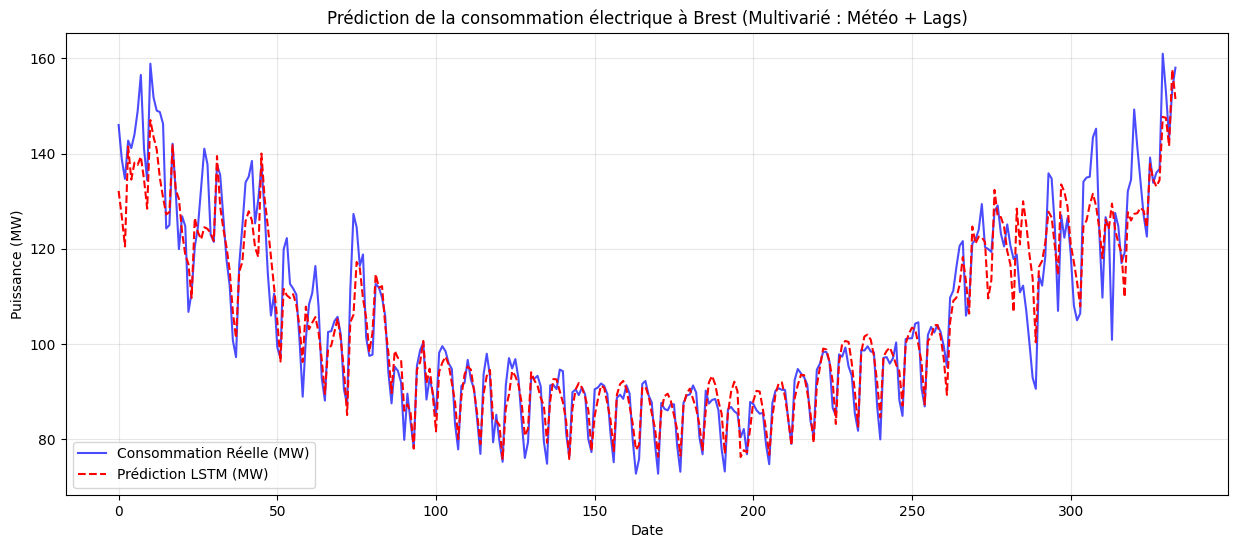

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Consommation Réelle (MW)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Prédiction LSTM (MW)', color='red', linestyle='--')

plt.title('Prédiction de la consommation électrique à Brest (Multivarié : Météo + Lags)')
plt.xlabel('Date')
plt.ylabel('Puissance (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. MAE : Mean Absolute Error (Erreur Absolue Moyenne)
mae = mean_absolute_error(y_actual, y_pred)

# 2. RMSE : Root Mean Squared Error (Erreur Quadratique Moyenne)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

# 3. MAPE : Mean Absolute Percentage Error (Erreur en Pourcentage)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

print(f"📊 Performances du modèle LSTM :")
print(f"MAE  : {mae:.2f} MW")
print(f"RMSE : {rmse:.2f} MW")
print(f"MAPE : {mape:.2f} %")

📊 Performances du modèle LSTM :
MAE  : 4.31 MW
RMSE : 6.05 MW
MAPE : 3.96 %


## Test du modèle de fondation MOIRAI ##

<br>
<br>
Les modèles de fondations, très connus pour le traitement d'images ou pour le NLP, arrivent depuis peu de temps pour les données tabulaires et les time series. La promesse : faire des prédictions en zero-shot learning, sans fine tuning sur nos propres data, avec seulement des données de "contexte".

Cette approche est émergente, les librairies sont encore mouvantes, pas simple d'arriver à les faire fonctionner.

<br>
<br>
Nous utilisons ici MOIRAI, un modèle de fondation à l'état de l'art, voyons ce qu'il est capable de faire .....

In [50]:
import torch
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
import uni2ts.model.moirai as moirai
from uni2ts.model.moirai import MoiraiModule, MoiraiForecast
# 1. On sélectionne ici les datas utilisées comme historique (ou contexte) par MOIRAI, soit les 200 jours avant le mois de décembre 2025
data_for_prediction = dataset_test.iloc[-230:-30].copy()
data_for_prediction.index = pd.to_datetime(data_for_prediction.index)

base_freq = "D"
data_for_prediction = data_for_prediction.asfreq(base_freq)

data_for_prediction = data_for_prediction.ffill()

# 2. Preparation du dataset au format GluonTS
# Ici, la date est l'index
dataset = PandasDataset(
    data_for_prediction,
    target="consommation",
    timestamp=None,
    freq=base_freq,
    feat_dynamic_real=features
)

# 3. Longueurs de prédiction et de contexte
requested_prediction_length = 30
context_length = 150

max_pred = len(data_for_prediction) - context_length
if max_pred <= 0:
    raise ValueError(
        f"Pas assez de donnees: len(data_for_prediction)={len(data_for_prediction)} "
        f"< context_length={context_length}."
    )

prediction_length = min(requested_prediction_length, max_pred)



module = MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-small")

predictor = MoiraiForecast(
    module=module,
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=len(features),
    past_feat_dynamic_real_dim=0
)

final_predictor = predictor.create_predictor(batch_size=32)
forecast_it = final_predictor.predict(dataset)



c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


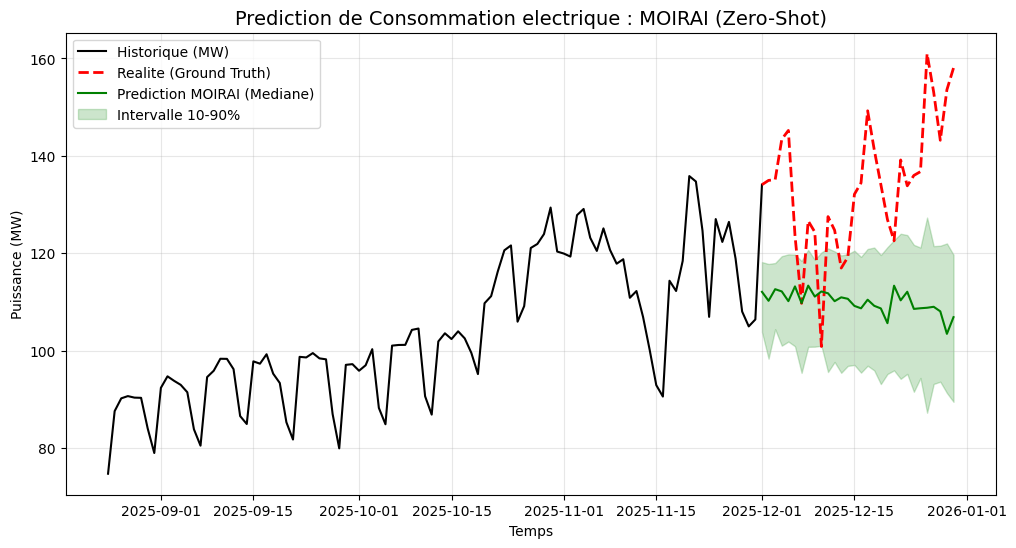

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. On recupere le premier (et seul) forecast de notre liste
forecasts = list(forecast_it)

if len(forecasts) == 0:
    raise ValueError(
        "Aucun forecast renvoyé."
    )
forecast_entry = forecasts[0]


plt.figure(figsize=(12, 6))


forecast_index = forecast_entry.index

# Normalise les types d'index (Period -> Timestamp) et les timezones
if isinstance(forecast_index, pd.PeriodIndex):
    forecast_index = forecast_index.to_timestamp()

series = dataset_test['consommation']


# Historique: on prend juste avant le debut de la prediction
history_end = forecast_index[0]
history = series.loc[:history_end].iloc[-100:]
plt.plot(history.index, history.values, label="Historique (MW)", color="black", linewidth=1.5)

actual = series.reindex(forecast_index)
plt.plot(actual.index, actual.values, label="Realite (Ground Truth)", color="red", linestyle="--", linewidth=2)

# 3. Trace de la mediane + intervalles
q50 = forecast_entry.quantile(0.5)
q90 = forecast_entry.quantile(0.9)
q10 = forecast_entry.quantile(0.1)

plt.plot(forecast_index, q50, color='g', label="Prediction MOIRAI (Mediane)")
plt.fill_between(forecast_index, q10, q90, color='g', alpha=0.2, label="Intervalle 10-90%")

plt.title("Prediction de Consommation electrique : MOIRAI (Zero-Shot)", fontsize=14)
plt.ylabel("Puissance (MW)")
plt.xlabel("Temps")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.show()
